# Download libraries

In [0]:
import torch
import torchvision 

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Download and prepare data

In [3]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000

learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1

torch.backends.cudnn.enabled = False # Why false 
torch.manual_seed(random_seed) # Why 1

# What it does?
## Torch.backends.cudnn
It enables benchmark mode in cudnn. Benchmark mode is good whenever your input sizes for your network do not vary. This way, cudnn will look for the optimal set of algorithms for that particular configuration (which takes some time). 
This usually leads to faster runtime. It's also worth mentioning that cuDNN uses nondeterministic algorithms which can be disabled setting torch.backends.cudnn.enabled = False.
But if your input sizes changes at each iteration, then cudnn will benchmark every time a new size appears, possibly leading to worse runtime performances.
## torch.manual_seed
Sets the seed for generating random numbers. 

In [0]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Normalize((0.1307,), (0.3081,))])),
                             batch_size=batch_size_train, 
                             shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Normalize((0.1307,), (0.3081,))])),
                             batch_size=batch_size_test, 
                             shuffle=True)

The values 0.1307 and 0.3081 used for the Normalize() transformation below are the global mean and standard deviation of the MNIST dataset, we'll take them as a given here.


In [0]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

# What it does?
## Enumerate()
It adds a counter to an iterable and returns it in a form of enumerate object. This enumerate object can then be used directly in for loops or be converted into a list of tuples using list() method.
**Ex:**
s1 = "geek"
print list(enumerate(s1,2)) 
//changing start index to 2 from 0 
print list(enumerate(s1,2)) 

Output:
[(0, 'g'), (1, 'e'), (2, 'e'), (3, 'k')]
[(2, 'g'), (3, 'e'), (4, 'e'), (5, 'k')]

## Next()
The next() function returns the next (or just first) item in an iterator.

In [6]:
example_data.shape

torch.Size([1000, 1, 28, 28])

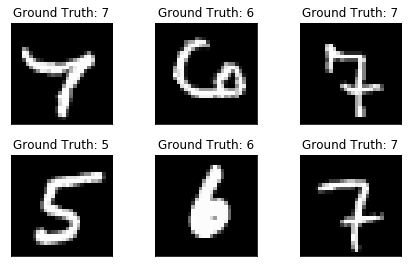

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
# fig

# Building the Network

We’ll be making use of four major functions in our CNN class:

1.    **torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)** – applies convolution
2.   **torch.nn.relu(x)** – applies ReLU
3.  **torch.nn.MaxPool2d(kernel_size, stride, padding)** – applies max pooling
4. **torch.nn.Linear(in_features, out_features)** – fully connected layer (multiply inputs by learned weights)

    
    
    


In [0]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
  def __init__(self):
    """
    D_in: input dimension
    H: dimension of hidden layer
    D_out: output dimension
    """
    super(SimpleCNN, self).__init__()
    
    self.cnn = nn.Sequential(
      # 1*28*28*batchSize
      nn.Conv2d(1, 10, kernel_size=5, stride=1, padding=1),
      nn.Dropout2d(),
      # 10*26*26*batchSize
      nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
      #10*13*13*batchSize       
      nn.ReLU(),
      #10*13*13*batchSize  
      nn.Conv2d(10, 20, kernel_size=4, stride=1, padding=1),
      nn.Dropout2d(),
      #20*12*12*batchSize
      nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
      #20*6*6*batchSize       
      nn.ReLU()
    )
    self.fc = nn.Sequential(
      nn.Linear(20 * 6 * 6 , 50),
      nn.ReLU(),
      nn.Linear(50, 10)
    )
  
  def forward(self, x):
    x_cnn = self.cnn(x)
    cnn_fc = x_cnn.view(-1, 20 * 6 * 6)
    fc_y = self.fc(cnn_fc)
    return F.log_softmax(fc_y)

# Initialize model

In [0]:
from torchsummary import summary
import torch.optim as optim

Pour verifier toutes les fonctions dans une class faire: dir(tla_-classe)
ex:dir(torch.nn)

In [0]:
# dir(torch.nn)

## Check CUDA

In [11]:

torch.cuda.is_available()
torch.cuda.current_device()
torch.cuda.get_device_name(0)

'Tesla T4'

In [0]:
# Returns the current GPU memory usage by 
# tensors in bytes for a given device
torch.cuda.memory_allocated()

# Returns the current GPU memory managed by the
# caching allocator in bytes for a given device
torch.cuda.memory_cached()

# Releases all unoccupied cached memory currently held by
# the caching allocator so that those can be used in other
# GPU application and visible in nvidia-smi
torch.cuda.empty_cache()

In [100]:
# You can check if it is on GPU device or not, for that you will have to check 
# if its parameters are on GPU or not, like:
model = SimpleCNN().cuda()
next(model.parameters()).is_cuda

True

In [101]:
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             260
         Dropout2d-2           [-1, 10, 26, 26]               0
         MaxPool2d-3           [-1, 10, 13, 13]               0
              ReLU-4           [-1, 10, 13, 13]               0
            Conv2d-5           [-1, 20, 12, 12]           3,220
         Dropout2d-6           [-1, 20, 12, 12]               0
         MaxPool2d-7             [-1, 20, 6, 6]               0
              ReLU-8             [-1, 20, 6, 6]               0
            Linear-9                   [-1, 50]          36,050
             ReLU-10                   [-1, 50]               0
           Linear-11                   [-1, 10]             510
Total params: 40,040
Trainable params: 40,040
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=momentum)

# Train Model

In [0]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [0]:
def train(epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    data = data.cuda()
    target = target.cuda()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(model.state_dict(), '/results/model.pth')
      torch.save(optimizer.state_dict(), '/results/optimizer.pth')

# Test Model

In [0]:
def test():
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data = data.cuda()
      target = target.cuda()
      output = model(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

# Go!

In [87]:
!mkdir /results/

mkdir: cannot create directory ‘/results/’: File exists


In [106]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3015, Accuracy: 1786/10000 (17%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.318098
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.322612
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.282612
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.296625
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.257823
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.244452
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.120614
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.110514
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.738924
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.725875
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.623025
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.231672
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.371405
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.902452
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.115312
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.029146
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.907752
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.333091
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.780223
Train Epoch: 1 [12160

# Error handling
**Error 1**: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same

Here s how I fixed it: 

```
model = SimpleCNN()
model.cuda()
...
def train(epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    data = data.cuda()
```
**Error 2 :** Target and input must have the same number of elements. target nelement (1000) != input nelement (10000)

Here s how I fixed it:
 Iwas using

```
Loss_fn = nn.BCELoss()
```
First I used BCELoss in a 10 classes problem while it should be a 2classe problem. Apparently this loss needs needs inputs and targets of the same shape, since each element individually could predict the occurrence of the class.  F.nll_loss(output, target) is more appropriate.


```
# During training
 loss = F.nll_loss(output, target)
 # During Test
 test_loss += F.nll_loss(output, target, size_average=False).item()
 # We remove the size_average because it not a batch, it one at the time
```





# Evaluating the Model's Performance

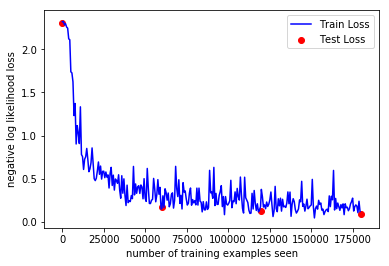

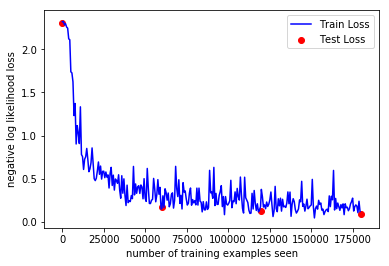

In [107]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


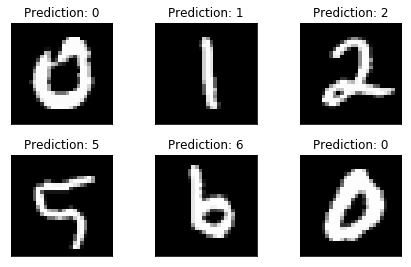

In [108]:
with torch.no_grad():
  output = model(example_data.cuda())
  
  fig = plt.figure()
  for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(
      output.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])

# Continued Training from Checkpoints

we can continue training from the state_dicts we saved during our first training run. We'll initialize a new set of network and optimizers.

In [0]:
continued_network = SimpleCNN().cuda()
continued_optimizer = optim.SGD(continued_network.parameters(), lr=learning_rate,
                                momentum=momentum)

In [0]:
network_state_dict = torch.load('/results/model.pth')
continued_network.load_state_dict(network_state_dict)

optimizer_state_dict = torch.load('/results/optimizer.pth')
continued_optimizer.load_state_dict(optimizer_state_dict)

In [112]:
for i in range(4,9):
  test_counter.append(i*len(train_loader.dataset))
  train(i)
  test()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 4 [0/60000 (0%)]	Loss: 0.471098
Train Epoch: 4 [640/60000 (1%)]	Loss: 0.534659
Train Epoch: 4 [1280/60000 (2%)]	Loss: 0.134836
Train Epoch: 4 [1920/60000 (3%)]	Loss: 0.124227
Train Epoch: 4 [2560/60000 (4%)]	Loss: 0.295947
Train Epoch: 4 [3200/60000 (5%)]	Loss: 0.054617
Train Epoch: 4 [3840/60000 (6%)]	Loss: 0.154323
Train Epoch: 4 [4480/60000 (7%)]	Loss: 0.122867
Train Epoch: 4 [5120/60000 (9%)]	Loss: 0.099395
Train Epoch: 4 [5760/60000 (10%)]	Loss: 0.280126
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.215712
Train Epoch: 4 [7040/60000 (12%)]	Loss: 0.258830
Train Epoch: 4 [7680/60000 (13%)]	Loss: 0.160442
Train Epoch: 4 [8320/60000 (14%)]	Loss: 0.085728
Train Epoch: 4 [8960/60000 (15%)]	Loss: 0.247751
Train Epoch: 4 [9600/60000 (16%)]	Loss: 0.147893
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.186051
Train Epoch: 4 [10880/60000 (18%)]	Loss: 0.024697
Train Epoch: 4 [11520/60000 (19%)]	Loss: 0.153598
Train Epoch: 4 [12160/60000 (20%)]	Loss: 0.093244
Train Epoch: 4 [12800/60000 (

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0705, Accuracy: 9769/10000 (97%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.171525
Train Epoch: 5 [640/60000 (1%)]	Loss: 0.269864
Train Epoch: 5 [1280/60000 (2%)]	Loss: 0.209771
Train Epoch: 5 [1920/60000 (3%)]	Loss: 0.106436
Train Epoch: 5 [2560/60000 (4%)]	Loss: 0.061246
Train Epoch: 5 [3200/60000 (5%)]	Loss: 0.222548
Train Epoch: 5 [3840/60000 (6%)]	Loss: 0.062972
Train Epoch: 5 [4480/60000 (7%)]	Loss: 0.061213
Train Epoch: 5 [5120/60000 (9%)]	Loss: 0.076934
Train Epoch: 5 [5760/60000 (10%)]	Loss: 0.232156
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.156943
Train Epoch: 5 [7040/60000 (12%)]	Loss: 0.179305
Train Epoch: 5 [7680/60000 (13%)]	Loss: 0.064692
Train Epoch: 5 [8320/60000 (14%)]	Loss: 0.154740
Train Epoch: 5 [8960/60000 (15%)]	Loss: 0.088458
Train Epoch: 5 [9600/60000 (16%)]	Loss: 0.138984
Train Epoch: 5 [10240/60000 (17%)]	Loss: 0.177910
Train Epoch: 5 [10880/60000 (18%)]	Loss: 0.187765
Train Epoch: 5 [11520/60000 (19%)]	Loss: 0.077251
Train Epoch: 5 [12160

Text(0, 0.5, 'negative log likelihood loss')

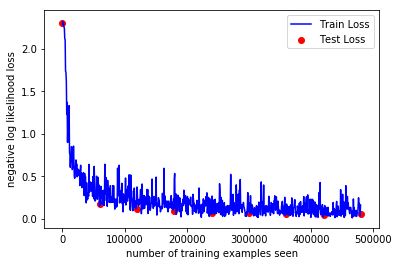

In [113]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')